In [1]:
import h5py
import numpy as np 

import matplotlib.pylab as plt
import sys; 
sys.path.append('/path.to.parent.dir') 
import os
cwd = os.getcwd()
# a = "~"+cwd+'/images_training.h5'
# a
# load data
with h5py.File("../Input/images_training.h5",'r') as H:
    data = np.copy(H['data']) 
with h5py.File("../Input/labels_training.h5",'r') as H:
    label = np.copy(H['label'])

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#reshape the data from (30000,28,28) to (30000, 784)
m=data.shape[1]*data.shape[2]
data1 = data.reshape(30000,m)
del data
# data1.shape

In [3]:
#check the amount of different labels
target = set()
for i in label:
    target.add(i)
d = len(list(target))

In [4]:
# ovr, e.g. label "1" vs. not label "1" 
# make 10 different label set, and combine them together
label1 = np.array([])
for i in range(d):
    label_tmp=np.copy(label)
    for tmp in range(len(label_tmp)):
        if label_tmp[tmp] != i:
            label_tmp[tmp] = 0
        else:
            label_tmp[tmp] = 1
    label_tmp= label_tmp.reshape(-1,1)
    if i == 0:
        label1 = np.copy(label_tmp)
    else:
        label1 = np.append(label1, label_tmp, axis=1)
del label_tmp

In [5]:
# apply min max scaler 
mindata = data1.min(axis=0)
maxdata = data1.max(axis=0)
data_normalize = (data1-mindata) / (maxdata - mindata)

In [6]:
# PCA class
class PCA():
    # calculate the covariance matrix, 
    def covariance_matrix(self, X, Y=None):
        # m is number of data, which is also the number of rows.
        m = X.shape[0]
        
        #each element in the row subtracts the mean of this row, 
        #it makes it's easier to calculate the covariance. 
        X = X - np.mean(X, axis=0)
        Y = X if Y == None else Y - np.mean(Y, axis=0)
        return 1 / m * np.matmul(X.T, Y)

    def transform(self, X, new_dimension):
        # new_dimension is the new dimension, which is the number of cloumns. 
        covariance_matrix = self.covariance_matrix(X)
        # calculate the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Arrange the feature vectors into a matrix ac-cording  to  the  
        # corresponding  feature  valuefrom  top  to  bottom,  
        # taking  the  first  k(new_dimension) rows
        idx = eigenvalues.argsort()[::-1]
        eigenvectors = eigenvectors[:, idx]
        eigenvectors = eigenvectors[:, :new_dimension]

        # eigenvectors is the matrix to reduce dimension 
        return np.matmul(X, eigenvectors), eigenvectors

In [7]:
# apply pca to training data
data_normalize, eigenvectors = PCA().transform(data_normalize, 260)

In [8]:
eigenvectors.shape

(784, 260)

In [9]:
data_normalize.shape

(30000, 260)

In [10]:
# add 1 to each training sample for w0 in weight 
forw0 = np.full((data_normalize.shape[0], 1), 1)
data_normalize = np.append(data_normalize, forw0, axis=1)
data_normalize.shape

(30000, 261)

In [11]:
# the loss function for logistic regression
def f(w, data,label):
    data = np.matrix(data)
    label = np.matrix(label)
    w = np.matrix(w)
    
    w=w.reshape(-1,1)
    
    z = data.dot(w)
    return np.sum(np.log(1+np.exp(z))- np.multiply(label,z) ,axis=0)

# the gradient function for the loss function
def jacobian(weights,inputs, targets ):
#     (weights, inputs, targets)
    inputs = np.matrix(inputs)
    targets = np.matrix(targets)
    weights = np.matrix(weights)
    weights=weights.reshape(-1,1)
    
    z = np.dot(inputs, weights)
    exp_z = np.exp(z)
#     print(exp_z)
    temp = -exp_z/(1 + exp_z) + targets
    dloss = -np.sum(np.multiply(temp,inputs), axis=0)
    dloss = dloss.flatten()
    return dloss

In [12]:
print("start training")
from scipy.optimize import minimize
import numpy.linalg as lng
import time
weights = np.array([])
t1 = time.time()
# for each label, train a logistic regression model
for i in range(d):
    # initialize weight
    weight = np.full((data_normalize.shape[1], 1), 0.1)
    current_label = (label1[:,i]).reshape(-1,1)
    #use scipy.optimize.minimize to get weight
    p = {"maxiter":400}
    result = minimize(f, weight,
                      jac =jacobian,method="L-BFGS-B",tol=1e-4,
                      args=(data_normalize,current_label), options = p) 
    weight = (result.x).reshape(-1,1)
    # combine weight together
    if i == 0:
        weights = weight
    else:
        weights = np.append(weights, weight, axis = 1)
t2 = time.time() 
print("finish training")

start training
finish training


In [13]:
# print training time
print(str(t2-t1),"seconds")

65.1877760887146 seconds


In [14]:
#load test data
with h5py.File('../Input/images_testing.h5','r') as H:
    data_testing = np.copy(H['data']) 
with h5py.File('../Input/labels_testing_2000.h5','r') as H:
    label_testing = np.copy(H['label'])

# reshape the data
data_testing = data_testing.reshape(5000,-1)
# do normalizing
data_testing = (data_testing-mindata) / (maxdata - mindata)
# PCA
data_testing = np.matmul(data_testing, eigenvectors)


In [15]:
# add 1 to each test data
forw0 = np.full((data_testing.shape[0], 1), 1)
data_testing = np.append(data_testing, forw0[0:5000], axis=1)
# do prediction
calculation = data_testing.dot(weights)

result = np.argmax(calculation, axis=1)

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
to_submit = np.copy(result)
result = result[0:2000]

confusion_matrix(label_testing, result)
cm = confusion_matrix(label_testing, result, labels=[0,1,2,3,4,5,6,7,8,9])

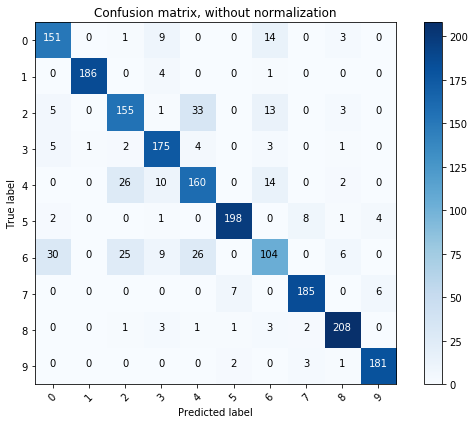

In [17]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(label_testing, result)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix, without normalization')


plt.show()

In [18]:
idx = 0
precisions = []
recalls = []
f1s = [] 
for idx in range(10):
    diag = cm[idx][idx]
    precision = round(diag/np.sum(cm[:,idx]),3)
    recall = round(diag/np.sum(cm[idx]),3)
    f1 = round((2*recall*precision)/(recall+precision),3)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print("for label",idx, " precision is ",precision," recall is ",recall," f1 is ",f1)

for label 0  precision is  0.782  recall is  0.848  f1 is  0.814
for label 1  precision is  0.995  recall is  0.974  f1 is  0.984
for label 2  precision is  0.738  recall is  0.738  f1 is  0.738
for label 3  precision is  0.825  recall is  0.916  f1 is  0.868
for label 4  precision is  0.714  recall is  0.755  f1 is  0.734
for label 5  precision is  0.952  recall is  0.925  f1 is  0.938
for label 6  precision is  0.684  recall is  0.52  f1 is  0.591
for label 7  precision is  0.934  recall is  0.934  f1 is  0.934
for label 8  precision is  0.924  recall is  0.95  f1 is  0.937
for label 9  precision is  0.948  recall is  0.968  f1 is  0.958


In [19]:
print("for label 0 to 9")
print("precisions: ",precisions)
print("recalls: ", recalls)
print("f1s: ",f1s)

for label 0 to 9
precisions:  [0.782, 0.995, 0.738, 0.825, 0.714, 0.952, 0.684, 0.934, 0.924, 0.948]
recalls:  [0.848, 0.974, 0.738, 0.916, 0.755, 0.925, 0.52, 0.934, 0.95, 0.968]
f1s:  [0.814, 0.984, 0.738, 0.868, 0.734, 0.938, 0.591, 0.934, 0.937, 0.958]


In [20]:
print("accuracy is ",accuracy_score(label_testing, result)*100, "%")

accuracy is  85.15 %


In [21]:
h = h5py.File('../Output/predicted_labels.h5', 'w')
dset = h.create_dataset('label', data=to_submit)

In [22]:
# with h5py.File('../Output/predicted_labels.h5','r') as H:
#     test_result = np.copy(H['label'])

In [23]:
# print("accuracy is ",accuracy_score(label_testing, test_result[0:2000])*100, "%")